In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import os
import numpy as np
import pandas as pd
import random
import shutil
import pathlib
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
from tqdm.auto import tqdm

torch.__version__

'2.9.0+cu128'

In [2]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!pip install kaggle
import kagglehub

In [5]:
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""
os.environ['KAGGLE_API_TOKEN'] = ""

In [6]:
# copy selected images into data directories
def copy_to_mini_directory(df, source_directory, destination_directory, label, train_percentage, n):

  label_df = df.loc[df[3] == label].reset_index()
  fnames_str = [str(fname_int) for fname_int in label_df[0]]
  train_test_split = int(n*train_percentage)
  test_length = n - train_test_split
  train_list = []
  test_list = []

  ii = 0
  while ii < train_test_split:
    fname_str = random.choice(fnames_str)
    source_file = source_directory + fname_str + '.jpg'
    fnames_str.remove(fname_str)
    if os.path.isfile(source_file):
      shutil.copy(source_file, destination_directory + '/train/' + label.lower() + '/')
      ii+=1

  ii = 0
  while ii < test_length:
    fname_str = random.choice(fnames_str)
    source_file = source_directory + fname_str + '.jpg'
    fnames_str.remove(fname_str)
    if os.path.isfile(source_file):
      shutil.copy(source_file, destination_directory + '/test/' + label.lower() + '/')
      ii+=1

In [7]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
def plot_transformed_images(image_paths, transform, n=3):
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [9]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  class_to_idx = {cls_name: ii for ii, cls_name in enumerate(classes)}

  return classes, class_to_idx

In [10]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int=10,
                          display_shape: bool = True):
  if n > 10:
    n = 10

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for ii, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1,n,ii+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put model in train mode
  model.train()

  # Set up train loss and train accuracy values
  train_loss = 0
  train_acc = 0

  # Loop through data batches in the DataLoader
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss and accumulate
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Zero optiomizer gradients
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [12]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Set up test loss and test accuracy values
  test_loss = 0
  test_acc = 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

    return test_loss, test_acc

In [13]:
# take in parameters required for the training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
          epochs: int = 5):

  # Create an empty dictionary for training results
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps for the given number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer=optimizer)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # return results
  return results

In [14]:
def plot_loss_curves(results: Dict[str, List[float]]):

  # Get loss values of the results dictionary
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # set up a plot
  plt.figure(figsize=(15,7))

  # plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [15]:
class ImageFolderCustom(Dataset):

  def __init__(self, targ_dir: str, transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int):
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [16]:
class ClothingClassificationModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [17]:
!kaggle datasets list

ref                                                                 title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                                 Chocolate Sales                                         468320  2026-01-04 14:23:35.490000          20686        384  1.0              
aliiihussain/amazon-sales-dataset                                   Amazon_Sales_Dataset                                   1297759  2026-02-01 11:37:12.353000           5445         97  1.0              
amar5693/student-performance-dataset                                Student Performance Dataset                             177286  2026-02-12 06:04:44.613000           1569         29

In [18]:
# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-small' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-small


In [19]:
os.listdir(path)

['myntradataset', 'images', 'styles.csv']

In [20]:
styles_df = pd.read_csv(path + '/' + 'styles.csv', sep=',', skiprows=1, header=None, names=np.arange(100))
styles_df = styles_df.dropna(axis=1, how='all')
styles_df.head()

/tmp/ipython-input-1646544332.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  styles_df = pd.read_csv(path + '/' + 'styles.csv', sep=',', skiprows=1, header=None, names=np.arange(100))


,0,1,2,3,4,5,6,7,8,9,10,11
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN


In [21]:
# count occurrences of each type of fashion item in column 4
item_counts = styles_df[3].value_counts()
print(item_counts[:10])

3
Topwear       15405
Shoes          7344
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1080
Eyewear        1073
Fragrance      1012
Sandal          963
Name: count, dtype: int64


In [22]:
# select 1000 of each of the top 4 categories at random
topwear = styles_df.loc[styles_df[3] == 'Topwear'].reset_index()
topwear

,index,0,1,2,3,4,5,6,7,8,9,10,11
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN
1,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN
2,5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,NaN,NaN
3,6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,NaN,NaN
4,7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,44436,30614,Men,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Sports,Nike Men Striped Black Jersey,NaN,NaN
15401,44437,13496,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts,NaN,NaN
15402,44439,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt,NaN,NaN
15403,44440,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,NaN,NaN


In [23]:
n_samples = 1000
topwear_idx = random.sample(range(0, len(topwear)), n_samples)
topwear_files = topwear.iloc[topwear_idx][0]
topwear_files

,0
9912,14326
4633,19640
14218,23037
11005,6598
2605,57426
...,...
8271,5892
109,13426
2158,11063
11804,37923


In [24]:
Shoes = styles_df.loc[styles_df[3] == 'Shoes'].reset_index()
Shoes_idx = random.sample(range(0, len(Shoes)), n_samples)
Shoes_files = Shoes.iloc[Shoes_idx][0]
Shoes_files

,0
600,14408
6214,59764
6056,49593
6285,20760
5822,45334
...,...
3508,45610
7287,8530
4501,4519
3908,10298


In [25]:
bags = styles_df.loc[styles_df[3] == 'Bags'].reset_index()
bags_idx = random.sample(range(0, len(bags)), n_samples)
bags_files = bags.iloc[bags_idx][0]
bags_files

,0
1187,38444
903,25288
1019,17112
291,21982
121,37087
...,...
765,1918
2648,24766
1296,42059
981,51955


In [26]:
bottomwear = styles_df.loc[styles_df[3] == 'Bottomwear'].reset_index()
bottomwear_idx = random.sample(range(0, len(bottomwear)), n_samples)
bottomwear_files = bottomwear.iloc[bottomwear_idx][0]
bottomwear_files

,0
325,7560
1753,41316
2032,19688
1821,43076
1511,11320
...,...
1877,48097
2594,13256
649,28943
805,11244


In [27]:
#shutil.rmtree('fashion_data_mini')

!mkdir fashion_data_mini

!mkdir -p fashion_data_mini/train/topwear
!mkdir -p fashion_data_mini/train/bottomwear
!mkdir -p fashion_data_mini/train/shoes
!mkdir -p fashion_data_mini/train/bags

!mkdir -p fashion_data_mini/test/topwear
!mkdir -p fashion_data_mini/test/bottomwear
!mkdir -p fashion_data_mini/test/shoes
!mkdir -p fashion_data_mini/test/bags

In [28]:
split_percentage = 0.75
n_samples = 1000
copy_to_mini_directory(styles_df, path + '/images/', 'fashion_data_mini', 'Topwear', split_percentage, n_samples)
copy_to_mini_directory(styles_df, path + '/images/', 'fashion_data_mini', 'Shoes', split_percentage, n_samples)
copy_to_mini_directory(styles_df, path + '/images/', 'fashion_data_mini', 'Bottomwear', split_percentage, n_samples)
copy_to_mini_directory(styles_df, path + '/images/', 'fashion_data_mini', 'Bags', split_percentage, n_samples)

In [29]:
!zip -r /content/fashion_data_mini.zip /content/fashion_data_mini

  adding: content/fashion_data_mini/ (stored 0%)
  adding: content/fashion_data_mini/train/ (stored 0%)
  adding: content/fashion_data_mini/train/shoes/ (stored 0%)
  adding: content/fashion_data_mini/train/shoes/29258.jpg (deflated 53%)
  adding: content/fashion_data_mini/train/shoes/39577.jpg (deflated 53%)
  adding: content/fashion_data_mini/train/shoes/36417.jpg (deflated 53%)
  adding: content/fashion_data_mini/train/shoes/14386.jpg (deflated 50%)
  adding: content/fashion_data_mini/train/shoes/18539.jpg (deflated 6%)
  adding: content/fashion_data_mini/train/shoes/19049.jpg (deflated 58%)
  adding: content/fashion_data_mini/train/shoes/12685.jpg (deflated 47%)
  adding: content/fashion_data_mini/train/shoes/44422.jpg (deflated 56%)
  adding: content/fashion_data_mini/train/shoes/36427.jpg (deflated 52%)
  adding: content/fashion_data_mini/train/shoes/50747.jpg (deflated 53%)
  adding: content/fashion_data_mini/train/shoes/21737.jpg (deflated 58%)
  adding: content/fashion_data_mi

In [30]:
data_path = Path("content/")
image_path = Path("fashion_data_mini")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'fashion_data_mini'.
There are 4 directories and 0 images in 'fashion_data_mini/train'.
There are 0 directories and 750 images in 'fashion_data_mini/train/shoes'.
There are 0 directories and 750 images in 'fashion_data_mini/train/bags'.
There are 0 directories and 750 images in 'fashion_data_mini/train/topwear'.
There are 0 directories and 750 images in 'fashion_data_mini/train/bottomwear'.
There are 4 directories and 0 images in 'fashion_data_mini/test'.
There are 0 directories and 250 images in 'fashion_data_mini/test/shoes'.
There are 0 directories and 250 images in 'fashion_data_mini/test/bags'.
There are 0 directories and 250 images in 'fashion_data_mini/test/topwear'.
There are 0 directories and 250 images in 'fashion_data_mini/test/bottomwear'.


In [31]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('fashion_data_mini/train'), PosixPath('fashion_data_mini/test'))

Random image path: fashion_data_mini/train/shoes/39206.jpg
Image class: shoes
Image height: 80
Image width: 60


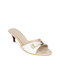

In [32]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: shoes | Image shape: (80, 60, 3) --> [height, width, color channels]')

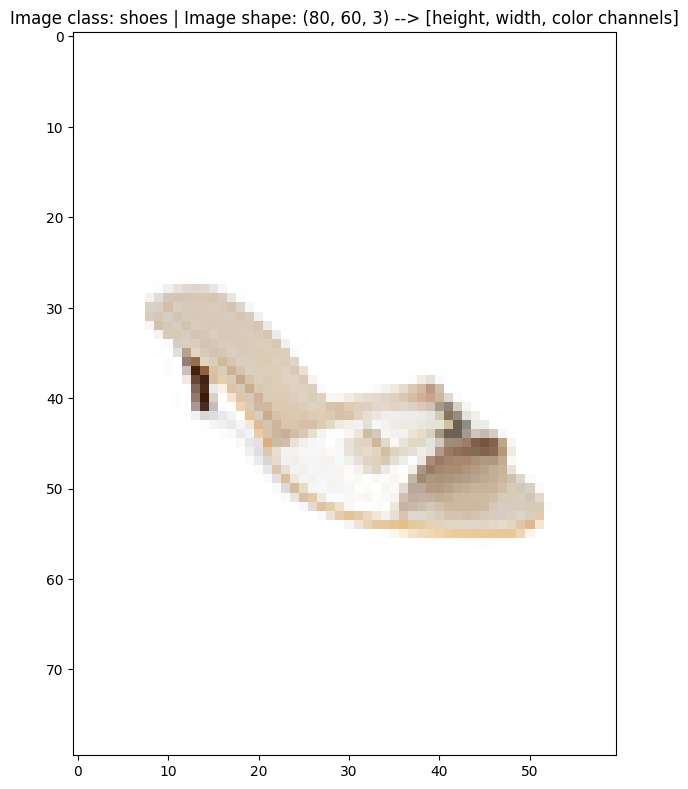

In [33]:
img_as_array = np.asarray(img)
plt.figure(figsize=(7,10))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} --> [height, width, color channels]")

In [34]:
find_classes(train_dir)

(['bags', 'bottomwear', 'shoes', 'topwear'],
 {'bags': 0, 'bottomwear': 1, 'shoes': 2, 'topwear': 3})

In [35]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

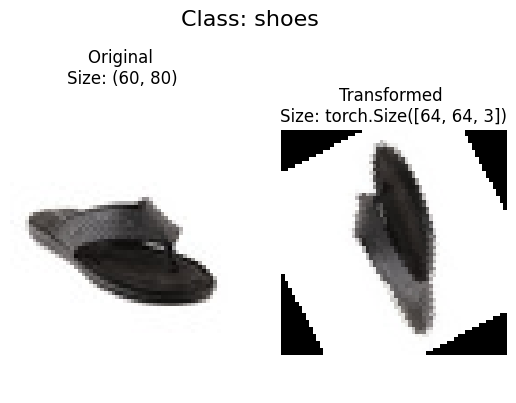

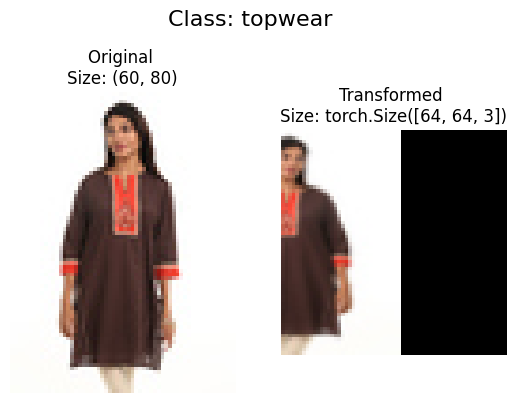

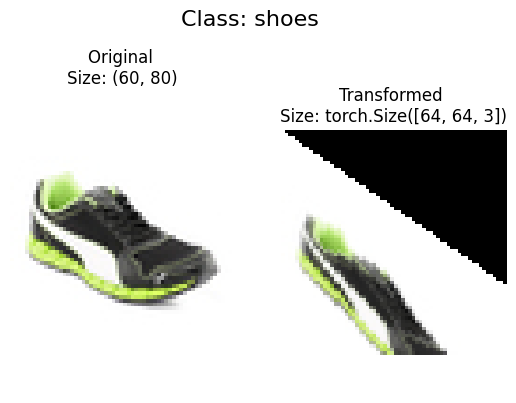

In [36]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_paths=image_path_list, transform=train_transforms, n=3)

In [37]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)

BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()

print(f"Creating dataloaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating dataloaders with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7ceba35e4770>,
 <torch.utils.data.dataloader.DataLoader at 0x7ceba56d8920>)

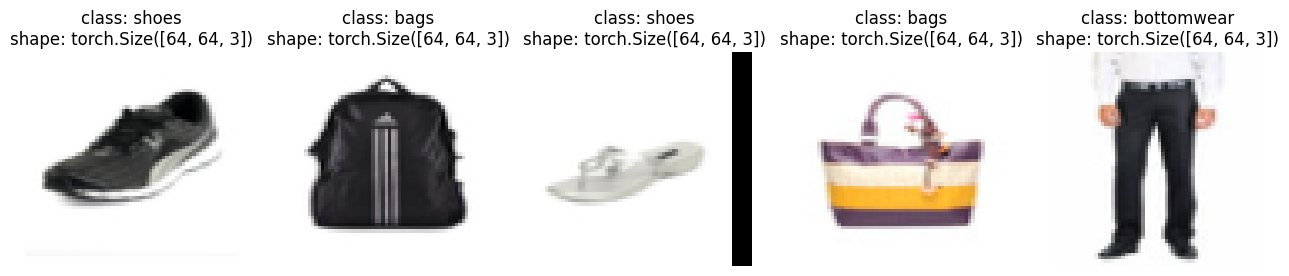

In [38]:
class_names, class_labels = find_classes(train_dir)
display_random_images(train_data, n=5, classes=class_names)

In [39]:
model_0 = ClothingClassificationModel(input_shape=3, hidden_units=10, output_shape = len(train_data.classes)).to(device)
model_0

ClothingClassificationModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=4, bias=True)
  )
)

In [40]:
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred,dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred,dim=1))}\n")
print(f"Actual label:\n{label_single}\n")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0412,  0.0018, -0.0113, -0.0111]], device='cuda:0')

Output prediction probabilities:
tensor([[0.2591, 0.2491, 0.2459, 0.2459]], device='cuda:0')

Output prediction label:
0

Actual label:
1



In [41]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
ClothingClassificationModel              [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [42]:
# set number of epochs
NUM_EPOCHS = 100

# create an instance of the model
model_0 = ClothingClassificationModel(input_shape=3,
                                      hidden_units=10,
                                      output_shape=len(train_data.classes)).to(device)

# set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train the model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0101 | train_acc: 0.5833 | test_loss: 0.2658 | test_acc: 0.9238
Epoch: 2 | train_loss: 0.6408 | train_acc: 0.7557 | test_loss: 0.2416 | test_acc: 0.9199
Epoch: 3 | train_loss: 0.5466 | train_acc: 0.7984 | test_loss: 0.1833 | test_acc: 0.9492
Epoch: 4 | train_loss: 0.5186 | train_acc: 0.8174 | test_loss: 0.1627 | test_acc: 0.9541
Epoch: 5 | train_loss: 0.4536 | train_acc: 0.8362 | test_loss: 0.1495 | test_acc: 0.9590
Epoch: 6 | train_loss: 0.4336 | train_acc: 0.8391 | test_loss: 0.1391 | test_acc: 0.9639
Epoch: 7 | train_loss: 0.4113 | train_acc: 0.8454 | test_loss: 0.1243 | test_acc: 0.9580
Epoch: 8 | train_loss: 0.4028 | train_acc: 0.8526 | test_loss: 0.1254 | test_acc: 0.9570
Epoch: 9 | train_loss: 0.3831 | train_acc: 0.8641 | test_loss: 0.1362 | test_acc: 0.9609
Epoch: 10 | train_loss: 0.3678 | train_acc: 0.8702 | test_loss: 0.1118 | test_acc: 0.9707
Epoch: 11 | train_loss: 0.3806 | train_acc: 0.8650 | test_loss: 0.1135 | test_acc: 0.9717
Epoch: 12 | train_l

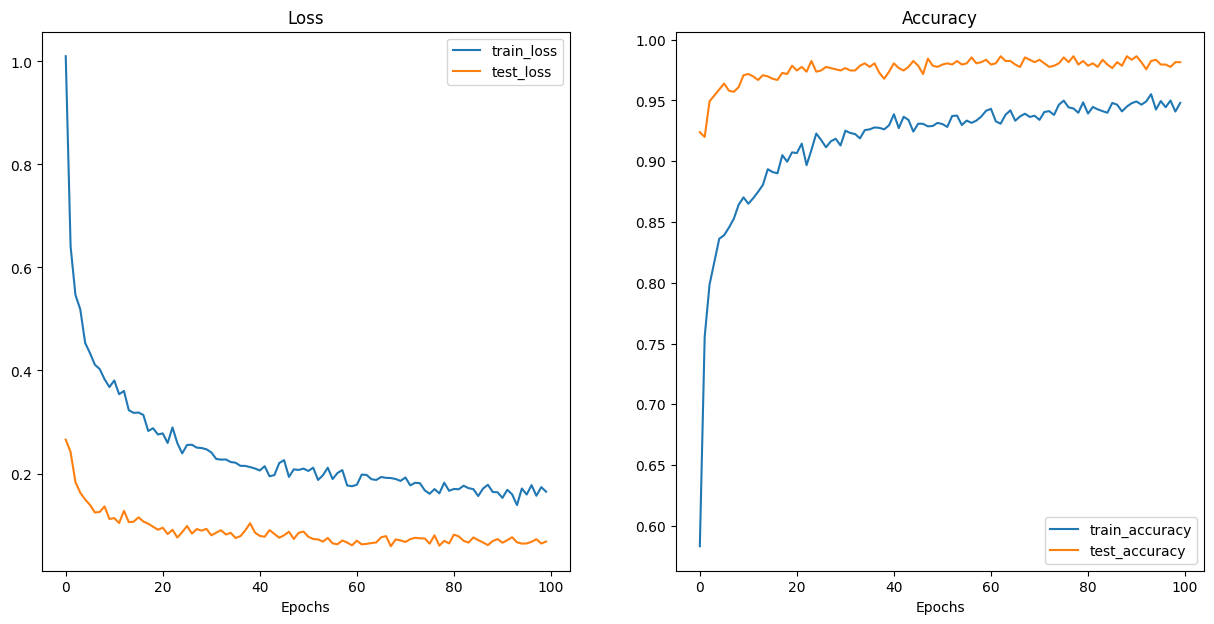

In [43]:
plot_loss_curves(model_0_results)